# 1. Library Import

In [1]:
import pandas as pd
from datetime import datetime

# Visulize
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Scrapping
import requests as rq
from bs4 import BeautifulSoup as bbs

# 2. Data Scrapping

In [2]:
def data_extract():
    url = 'https://www.worldometers.info/coronavirus/'
    try:
        response = rq.get(url)
        data = bbs(response.text, 'html.parser')
        all_data = []
        column = []
        for k in data.findAll('table', {'id': 'main_table_countries_today'}):
            for i in k.findAll('tr'):
                temp = []
                for j in i.findAll('th')[:8]:
                    column.append(j.text)
                for j in i.findAll('td')[:8]:
                    j = j.text.strip().replace(',', '')
                    if j:
                        try:
                            val = int(j)
                        except:
                            val = j
                    else:
                        val = 0
                    temp.append(val)
                if temp:
                    all_data.append(temp)
        column_len = len(all_data[0])
        df = pd.DataFrame(all_data, columns=column[:column_len])
        df = df.drop(axis=0, index=[df.shape[0]-1])
        df = df.groupby('Country,Other').first()
        df = df.sort_values(by=['TotalCases'], ascending=False)
        date = pd.DataFrame(
            df.shape[0]*[[datetime.now().strftime("%d %b,%Y")]], index=df.index.values, columns=['Date'])
        df = pd.concat([df, date], axis=1)
        df.to_csv('Last_updated.csv')
    except:
        df = pd.read_csv('Last_updated.csv', index_col=0)
        for i in df.columns[:-1]:
            df[i] = pd.to_numeric(df[i])

    return df

# 3. Data Preprocess

In [3]:
def data_process(df, val=None):
    processed_data = {}
    if val:
        df = df[:val]
    processed_data['country'] = df.index.values
    processed_data['recover'] = df.TotalRecovered/df.TotalCases
    processed_data['active'] = (
        df.ActiveCases-df['Serious,Critical'])/df.TotalCases
    processed_data['critical'] = df['Serious,Critical']/df.TotalCases
    processed_data['death'] = df.TotalDeaths/df.TotalCases

    processed_data['ac_recover'] = df.TotalRecovered
    processed_data['ac_active'] = (df.ActiveCases-df['Serious,Critical'])
    processed_data['ac_critical'] = df['Serious,Critical']
    processed_data['ac_death'] = df.TotalDeaths

    total_recover = sum(df.TotalRecovered)
    total_active = sum(df.ActiveCases)
    total_death = sum(df.TotalDeaths)

    processed_data['w_recover'] = df.TotalRecovered/total_recover
    processed_data['w_active'] = df.ActiveCases/total_active
    processed_data['w_death'] = df.TotalDeaths/total_death

    processed_data['date'] = df.Date[0]
    return processed_data

# 4. Data Bar Plot Country wise

In [4]:
def data_plot(main_data, save=True):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)

    plt.bar(main_data['country'], main_data['recover'],
            color='limegreen', edgecolor='white', label='Recover')
    plt.bar(main_data['country'], main_data['active'], bottom=main_data['recover'],
            color='darkorange', edgecolor='white', label='Active')
    plt.bar(main_data['country'], main_data['critical'], bottom=main_data['recover'] +
            main_data['active'], color='crimson', edgecolor='white', label='Critical')
    plt.bar(main_data['country'], main_data['death'], bottom=main_data['recover'] +
            main_data['active']+main_data['critical'], color='darkred', edgecolor='white', label='Death')

    plt.xlabel("Country Name", fontsize=25)
    plt.ylabel('Patient Number in Percentage', fontsize=25)
    plt.title('Effect of COVID-19 Until '+main_data['date'], fontsize=25)

    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    xtickNames = ax.set_xticklabels(main_data['country'])

    ax.legend(fontsize=15, loc='lower left')

    plt.setp(xtickNames, rotation=30, fontsize=15)
    if save:
        plt.savefig('Image/Corona.png')
    plt.show()

# 5. WordCloud

In [5]:
def show_wordcloud(main_data, save=True):
    stopwords = set(STOPWORDS)

    data = {i: j for i, j in zip(main_data['country'], main_data['ac_death'])}
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=len(data),
        max_font_size=80,
        scale=3,
        random_state=200
    ).generate_from_frequencies(data).recolor(random_state=63008)

    plt.figure(figsize=(16, 8), facecolor='white', edgecolor='blue')
    plt.title('Effect of COVID-19 Until ' +
              main_data['date'], fontsize=25)
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud)
    if save:
        plt.savefig('Image/Corona Stats Country wise.png')
    plt.show()

# 6. Data Bar Plot World Wide

In [6]:
def data_stat(main_data, index=1, save=True):
    index -= 1
    row = ['w_recover', 'w_active', 'w_death']
    color = ['limegreen', 'darkorange', 'darkred']
    name = row[index]
    label = name.split('_')[-1].capitalize()
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111)
    plt.bar(main_data['country'], main_data[name],
            color=color[index], edgecolor='white', label=label)

    for i, j in enumerate(main_data[name]):
        ax.text(i, j, '{:.2f}%'.format(100*j),
                ha='center', va='bottom', fontsize=15)

    plt.xlabel("Country Name", fontsize=25)
    plt.ylabel('Patient Number in Percentage', fontsize=25)
    plt.title('COVID-19 {} Patient Until {}'.format(label,
                                                    main_data['date']), fontsize=25)

    ax.set_yticklabels([])
    xtickNames = ax.set_xticklabels(main_data['country'])

    ax.legend(fontsize=25, loc='upper right')

    plt.setp(xtickNames, rotation=30, fontsize=15)
    if save:
        plt.savefig('Image/'+' Corona '+label+'.png')

    plt.show()

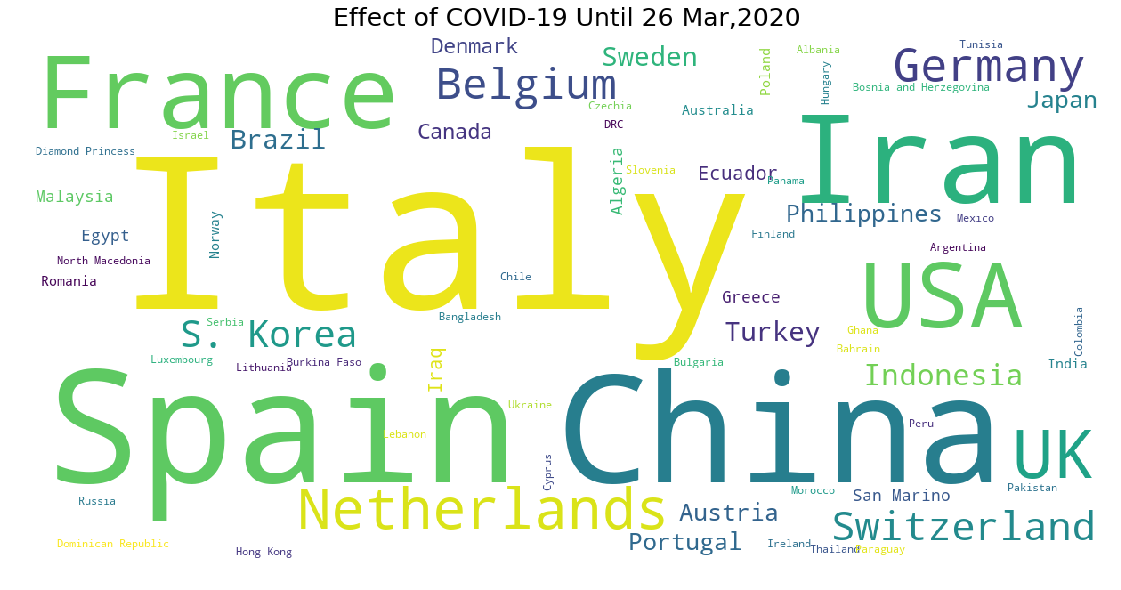

In [7]:
df = data_extract()
df_process = data_process(df)
show_wordcloud(df_process, True)

In [8]:
df = data_extract()
df_process = data_process(df, 15)

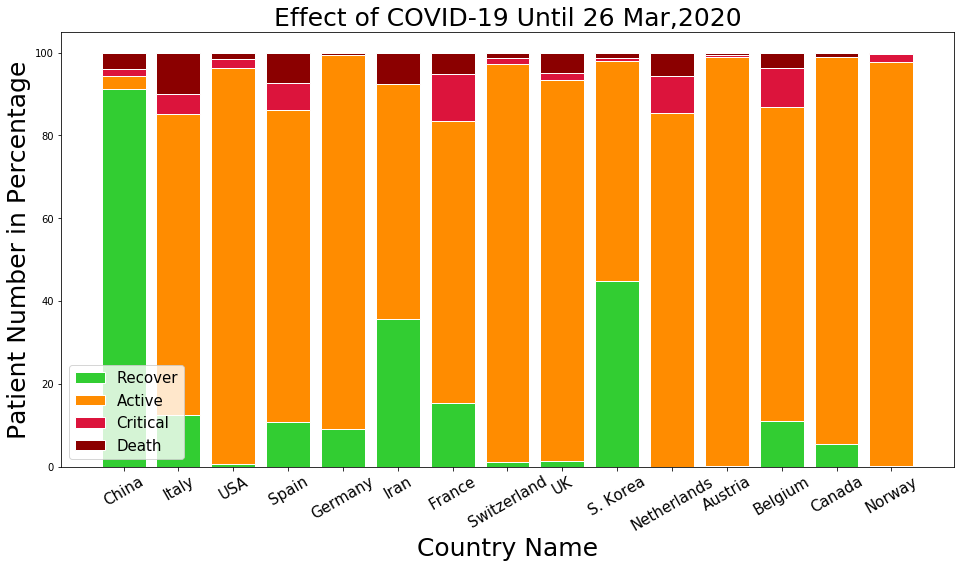

In [9]:
data_plot(df_process)

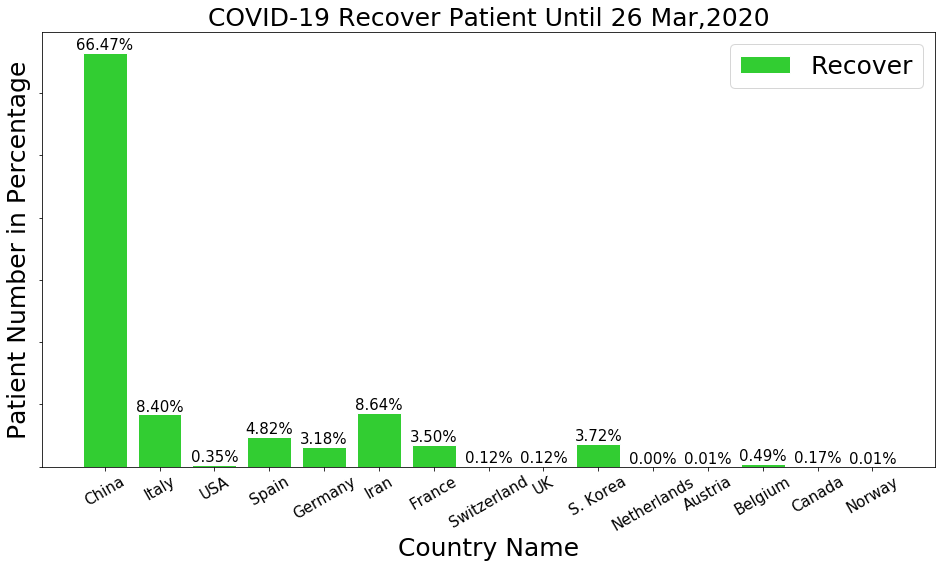

In [10]:
data_stat(df_process, 1)

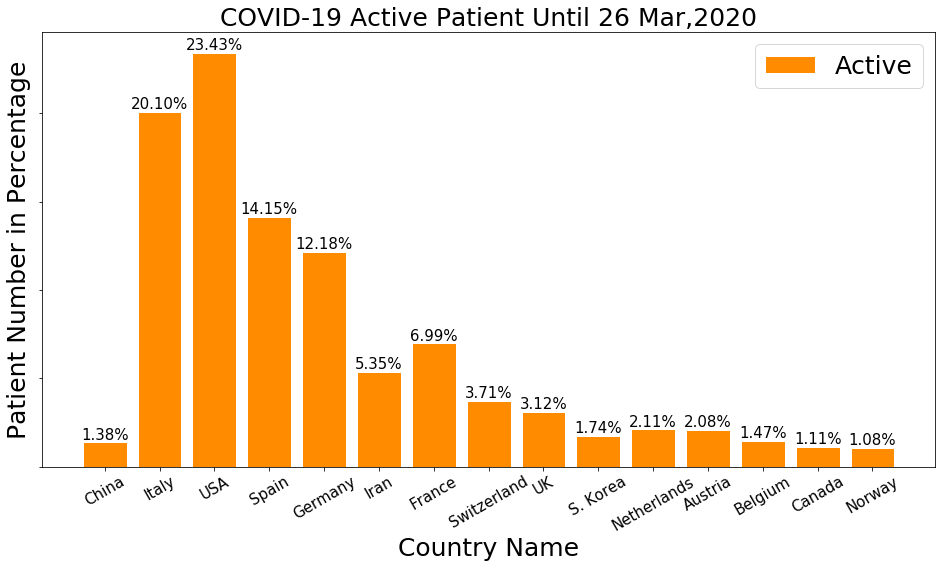

In [11]:
data_stat(df_process, 2)

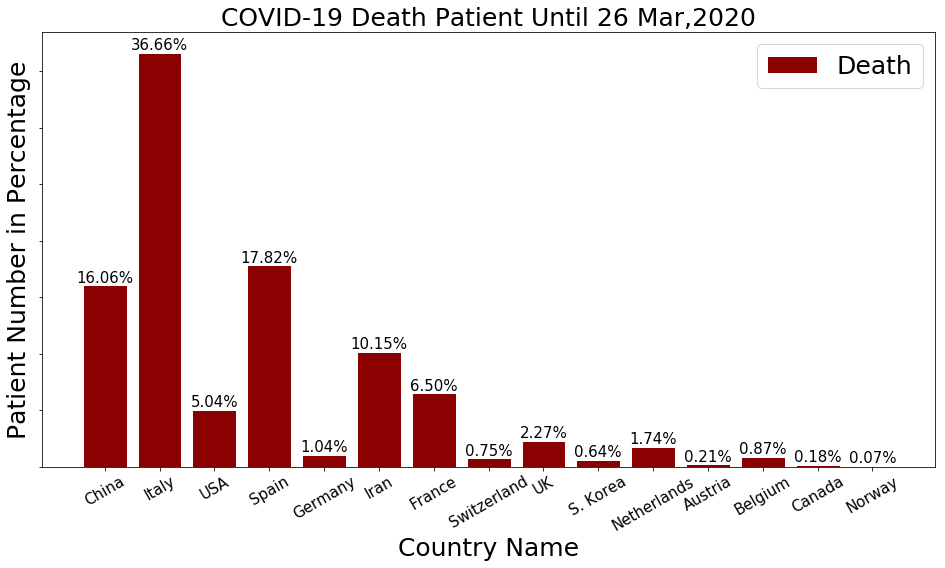

In [12]:
data_stat(df_process, 3, True)